In [1]:
import tensorflow as tf
from tensorflow import keras

from keras.layers import Conv1D , Dropout , Flatten , MaxPooling1D, Dense, Input, BatchNormalization , Dropout
from keras.layers.core import Lambda
from keras.models import Model , load_model , model_from_json
import keras.backend as K

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import random
import h5py
from IPython.display import Image

Using TensorFlow backend.


In [2]:
def custom_loss(y_error): 
    def loss(y_true, y_pred):
        delta = K.square(y_true - y_pred)
        s = K.log(K.square(y_error))   
        return tf.divide((1/2 * delta) , K.square(y_error) ) + (1/2 * s)
    return loss

In [3]:
def ApogeeDR14GaiaDR2(dim_t , dim_n, dropout_iterations = 100): 
    """
    INPUT: 
    dim_t - number of time steps of spectrum 
    dim_n - number of features of spectrum
    """
    
    #SPECTRUM TO LUINOSITY
    dim_1 = 1 # number of corrected magnitude for one example 
    units = 1 #number of final output for one example
    
    inputs_spectra = Input(shape=(dim_t, dim_n), name="pseudo-lum-input") 
    inputs_mag = Input(shape=(dim_1,), name="K_mag")
    inputs_error_paralaje = Input(shape=(dim_1,), name="error_paralaje")
    
    #x_parallax_list = []
    
    #for i in range(droput_iterations):
    x_parallax = Conv1D(filters=2, kernel_size=3, activation='relu')(inputs_spectra)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)

    x_parallax = Conv1D(filters=4, kernel_size=3, activation='relu')(x_parallax)
    x_parallax = BatchNormalization()(x_parallax)
    x_parallax = MaxPooling1D(pool_size=2)(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)

    x_parallax = Flatten()(x_parallax)
    x_parallax = Dense(128, activation='relu')(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
        
    x_parallax = Dense(64, activation='relu')(x_parallax) 
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
    x_parallax = Dense(32, activation='relu')(x_parallax)
    #x_parallax = Dropout(0.3)(x_parallax, training=True)
    x_parallax = Dense(units, activation='softplus', name="pseudo-lum")(x_parallax) 

    #OFFSET CORRECTION : (optimization)
    inputs_offset = Input(shape=(3,), name="offset-input")
    x_offset = Dense(64, activation='relu')(inputs_offset)
    x_offset = Dense(32, activation='relu')(x_offset) 
    x_offset = Dense(units, activation='tanh', name="offset")(x_offset) 
    
    #Functions
    outputs_parallax = Lambda(lambda function: tf.math.multiply(function[0], tf.math.pow(10., 
                              tf.math.multiply(-0.2, function[1]))),
                              name='parallax')([x_parallax, inputs_mag])
    
    outputs_parallax_with_offset = Lambda(lambda function: tf.math.add(function[0], function[1]),
                                          name="sum-parallax-offset")([outputs_parallax, x_offset]) 
    
    #Model setup
    model =  Model(inputs = [inputs_spectra,inputs_mag, inputs_offset,inputs_error_paralaje],outputs = [outputs_parallax_with_offset])
    
    model.compile(loss=[custom_loss(y_error=inputs_error_paralaje)], optimizer='adam', metrics=['mse']) 
    
    return model 

#### Data load 

In [4]:
# Cargamos los datos
path_local_data = '/home/anell/Desktop/Bovy/AnellExercises/Fits_files'
#path_local_data = '/home/bapanes/Research-Now/local/astronn-local/apo-gaia/'

with h5py.File(f'{path_local_data}/apogeedr14_gaiadr2_with_spectrum_probando_rendimiento_2.h5','r') as F:  
    parallax = np.array(F['parallax'])
    parallax_error = np.array(F['parallax_err'])
    spectra = np.array(F['spectra'])
    Kmag = np.array(F['corrected_magnitude_K'])
    bp_rp = np.array(F['bp_rp'])
    Gmag = np.array(F['phot_g_mean_mag'])
    teff = np.array(F['NN_teff'])
    apogee_id = np.array(F['APOGEE_ID'])
    snr = np.array(F['SNR'])
    fe_h = np.array(F['Fe/H'])
    path_spectra = np.array(F['Path_spectra'])

In [5]:
parallax.shape , spectra.shape , Kmag.shape

((60986,), (60986, 7514), (60986,))

In [6]:
#Establecemos las variables que entrarán a la red y corregimos sus dimensiones
X = np.expand_dims(spectra, axis = 2)
Y = np.expand_dims(parallax, axis = 1)
K_mag = np.expand_dims(Kmag, axis = 1)
Y_error = np.expand_dims(parallax_error, axis = 1)

# Normalizamos Gmag , el color (G_bp - G_rp) y teff
Gmag_std = np.std(Gmag)
Gmag_mean = np.mean(Gmag)
Gmag_norm = (Gmag - Gmag_mean) / Gmag_std

bp_rp_std = np.std(bp_rp)
bp_rp_mean = np.mean(bp_rp)
bp_rp_norm = (bp_rp - bp_rp_mean) / bp_rp_std

teff_std = np.std(teff)
teff_mean = np.mean(teff)
teff_norm = (teff - teff_mean) / teff_std

G_mag = np.expand_dims(Gmag_norm, axis=1)
Bp_Rp = np.expand_dims(bp_rp_norm, axis=1)
Teff = np.expand_dims(teff_norm, axis=1)

X_offset = np.concatenate((G_mag, Bp_Rp , Teff), axis = 1) 

In [7]:
print(X.shape , Y.shape, K_mag.shape, X_offset.shape,Y_error.shape)

(60986, 7514, 1) (60986, 1) (60986, 1) (60986, 3) (60986, 1)


#### SNR cut

In [8]:
high_snr_idx = []
low_snr_idx = []

for i in range(len(snr)):
    if snr[i] >= 200:           
        high_snr_idx.append(i)
    else:
        low_snr_idx.append(i)

random.seed(10)
random.shuffle(high_snr_idx)
random.seed(60)
random.shuffle(low_snr_idx)

#### Estos valores pueden ser comparados con Bovy train-test separation, 

Apart from taht we should be more clear about data preparation and evaluation

get consistent and repeatable accuracy using train and validation approach <br>
undestand the process of validation (draft about probability_distributions) <br> 
check the precision on the test data using baseline separation <br>
compute learning curve, following Fig 1. of Nguyen et. al.<br>
try with percentual mse, such that low and high parallax values weight the same <br>

initially we can consider SNR>200 for train-valid and SNR<200 for test <br>
understand why it is possible to make this separation and hope for consistent results <br>

compare to Bovy using this data separation, using global precision and learning curve<br>

How well are we doing with respect to Bovy?

In [9]:
#Image("/home/bapanes/Research-Now/TesisAnell/Figures/learning_curve_genoma.png")
#Image("learning_curve_genoma.png")

In [10]:
print("SNR>200: %d, else: %d"%(len(high_snr_idx), len(low_snr_idx)))

SNR>200: 27721, else: 33265


### Diseño Experimental:

Consideraré train (0.8) y valid (0.2)

train_val_1 $\rightarrow$  177 (train) + 44 (valid) = 221

train_val_2 $\rightarrow$  400 (train) + 100 (valid) = 500

train_val_3 $\rightarrow$  800 (train) + 200 (valid) = 1000

train_val_4 $\rightarrow$  2400 (train) + 600 (valid) = 3000

train_val_5 $\rightarrow$  6400 (train) + 1600 (valid) = 8000

train_val_6 $\rightarrow$  12000 (train) + 3000 (valid) = 15000

train_val_7 $\rightarrow$  22177 (train) + 5594 (valid) = 27771

test $\rightarrow$ 33265

In [11]:
X_high_snr = X[high_snr_idx]
Y_high_snr = Y[high_snr_idx]
K_mag_high_snr = K_mag[high_snr_idx]
X_offset_high_snr = X_offset[high_snr_idx]
Y_error_high_snr = Y_error[high_snr_idx]

X_low_snr = X[low_snr_idx]
Y_low_snr = Y[low_snr_idx]
K_mag_low_snr = K_mag[low_snr_idx]
X_offset_low_snr = X_offset[low_snr_idx]
Y_error_low_snr = Y_error[low_snr_idx]

In [12]:
X_train_val_1 = X_high_snr[:221]
Y_train_val_1 = Y_high_snr[:221]
K_mag_train_val_1 = K_mag_high_snr[:221]
X_offset_train_val_1 = X_offset_high_snr[:221]
Y_error_train_val_1 = Y_error_high_snr[:221]

X_train_val_2 = X_high_snr[221:721]
Y_train_val_2 = Y_high_snr[221:721]
K_mag_train_val_2 = K_mag_high_snr[221:721]
X_offset_train_val_2 = X_offset_high_snr[221:721]
Y_error_train_val_2 = Y_error_high_snr[221:721]

X_train_val_3 = X_high_snr[721:1721]
Y_train_val_3 = Y_high_snr[721:1721]
K_mag_train_val_3 = K_mag_high_snr[721:1721]
X_offset_train_val_3 = X_offset_high_snr[721:1721]
Y_error_train_val_3 = Y_error_high_snr[721:1721]

X_train_val_4 = X_high_snr[1721:4721]
Y_train_val_4 = Y_high_snr[1721:4721]
K_mag_train_val_4 = K_mag_high_snr[1721:4721]
X_offset_train_val_4 = X_offset_high_snr[1721:4721]
Y_error_train_val_4 = Y_error_high_snr[1721:4721]

X_train_val_5 = X_high_snr[4721:12721]
Y_train_val_5 = Y_high_snr[4721:12721]
K_mag_train_val_5 = K_mag_high_snr[4721:12721]
X_offset_train_val_5 = X_offset_high_snr[4721:12721]
Y_error_train_val_5 = Y_error_high_snr[4721:12721]

X_train_val_6 = X_high_snr[12721:]
Y_train_val_6 = Y_high_snr[12721:]
K_mag_train_val_6 = K_mag_high_snr[12721:]
X_offset_train_val_6 = X_offset_high_snr[12721:]
Y_error_train_val_6 = Y_error_high_snr[12721:]

X_train_val_7 = X_high_snr
Y_train_val_7 = Y_high_snr
K_mag_train_val_7 = K_mag_high_snr
X_offset_train_val_7 = X_offset_high_snr
Y_error_train_val_7 = Y_error_high_snr

X_test = X_low_snr
Y_test = Y_low_snr
K_mag_test = K_mag_low_snr
X_offset_test = X_offset_low_snr
Y_error_test = Y_error_low_snr
snr_test = snr[low_snr_idx]

In [13]:
print(Y_train_val_1.shape , Y_train_val_2.shape , Y_train_val_3.shape, Y_train_val_4.shape , 
      Y_train_val_5.shape,Y_train_val_6.shape ,Y_train_val_7.shape , Y_test.shape)

(221, 1) (500, 1) (1000, 1) (3000, 1) (8000, 1) (15000, 1) (27721, 1) (33265, 1)


#### Model

In [14]:
n_timesteps, n_features = X_train_val_7.shape[1], X_train_val_7.shape[2]

Global_model = ApogeeDR14GaiaDR2(n_timesteps , n_features)

Global_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pseudo-lum-input (InputLayer)   (None, 7514, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 7512, 2)      8           pseudo-lum-input[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 7512, 2)      8           conv1d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 3756, 2)      0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [15]:
#Global_model.compile(optimizer='adam', loss= None, metrics=['mse'])

path_local = "/home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss"

earlystopper = EarlyStopping(monitor='val_loss', patience=50, verbose=1, min_delta=1e-7)
checkpoint = ModelCheckpoint(f'{path_local}/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5', monitor='val_loss', 
                             verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=5, min_lr=0.000000001)

callbacks=[reduce_lr, checkpoint, earlystopper]

Global_model.fit([X_train_val_3, K_mag_train_val_3, X_offset_train_val_3,Y_error_train_val_3], Y_train_val_3,epochs=200, 
                 batch_size=128, verbose=1, shuffle="batch" ,callbacks=callbacks,validation_split=0.2)


Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 2s 2ms/step - loss: 7032.2049 - mse: 16.2338 - val_loss: 6534.3346 - val_mse: 11.3679

Epoch 00001: val_loss improved from inf to 6534.33465, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 2/200
800/800 [==============================] - 1s 922us/step - loss: 6447.4136 - mse: 15.1053 - val_loss: 5849.5833 - val_mse: 10.1787

Epoch 00002: val_loss improved from 6534.33465 to 5849.58327, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 3/200
800/800 [==============================] - 1s 992us/step - loss: 5488.9433 - mse: 13.0039 - val_loss: 5036.8604 - val_mse: 8.7642

Epoch 00003: val_loss improved from 5849.58327 to 5036.86044, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Cus

800/800 [==============================] - 1s 1ms/step - loss: 59.4720 - mse: 0.1921 - val_loss: 4509.2750 - val_mse: 7.8790

Epoch 00029: val_loss improved from 4521.65283 to 4509.27502, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 30/200
800/800 [==============================] - 1s 1ms/step - loss: 53.6533 - mse: 0.1758 - val_loss: 4501.7945 - val_mse: 7.8715

Epoch 00030: val_loss improved from 4509.27502 to 4501.79451, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 31/200
800/800 [==============================] - 1s 931us/step - loss: 48.8333 - mse: 0.1619 - val_loss: 4491.4057 - val_mse: 7.8588

Epoch 00031: val_loss improved from 4501.79451 to 4491.40566, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 32/200
800/800 [==========================

800/800 [==============================] - 1s 1ms/step - loss: 8.1573 - mse: 0.0374 - val_loss: 4028.6193 - val_mse: 6.9259

Epoch 00059: val_loss improved from 4088.69674 to 4028.61934, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 60/200
800/800 [==============================] - 1s 1ms/step - loss: 7.9412 - mse: 0.0367 - val_loss: 3954.7139 - val_mse: 6.7902

Epoch 00060: val_loss improved from 4028.61934 to 3954.71395, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 61/200
800/800 [==============================] - 1s 1ms/step - loss: 7.6153 - mse: 0.0357 - val_loss: 3883.7022 - val_mse: 6.6631

Epoch 00061: val_loss improved from 3954.71395 to 3883.70218, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 62/200
800/800 [==============================]

Epoch 85/200
800/800 [==============================] - 1s 1ms/step - loss: 2.6837 - mse: 0.0204 - val_loss: 1172.3000 - val_mse: 2.1939

Epoch 00085: val_loss improved from 1276.81443 to 1172.30002, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 86/200
800/800 [==============================] - 1s 1ms/step - loss: 2.5614 - mse: 0.0200 - val_loss: 1074.7958 - val_mse: 2.0296

Epoch 00086: val_loss improved from 1172.30002 to 1074.79583, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 87/200
800/800 [==============================] - 1s 1ms/step - loss: 2.4743 - mse: 0.0196 - val_loss: 969.3518 - val_mse: 1.8526

Epoch 00087: val_loss improved from 1074.79583 to 969.35176, saving model to /home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Modelo_1_D3_ReplicaBovy_Custom_Loss_2.h5
Epoch 88/200
800/800 [====================

800/800 [==============================] - 1s 813us/step - loss: 0.1336 - mse: 0.0123 - val_loss: 567.0873 - val_mse: 1.0636

Epoch 00114: val_loss did not improve from 536.57272
Epoch 115/200
800/800 [==============================] - 1s 805us/step - loss: 0.1203 - mse: 0.0123 - val_loss: 568.2633 - val_mse: 1.0631

Epoch 00115: val_loss did not improve from 536.57272
Epoch 116/200
800/800 [==============================] - 1s 802us/step - loss: 0.1065 - mse: 0.0122 - val_loss: 570.5257 - val_mse: 1.0649

Epoch 00116: val_loss did not improve from 536.57272
Epoch 117/200
800/800 [==============================] - 1s 797us/step - loss: 0.0959 - mse: 0.0122 - val_loss: 571.6690 - val_mse: 1.0648

Epoch 00117: val_loss did not improve from 536.57272
Epoch 118/200
800/800 [==============================] - 1s 805us/step - loss: 0.0658 - mse: 0.0121 - val_loss: 572.8851 - val_mse: 1.0649

Epoch 00118: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00118: val_los

800/800 [==============================] - 1s 845us/step - loss: -0.0313 - mse: 0.0118 - val_loss: 596.9339 - val_mse: 1.0886

Epoch 00153: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.

Epoch 00153: val_loss did not improve from 536.57272
Epoch 00153: early stopping


#### simple evaluations on test sample (SNR < 200)

In [16]:
J_test , mse_test = Global_model.evaluate([X_test, K_mag_test , X_offset_test, Y_error_test], Y_test)

33265/33265 [==============================] - 11s 340us/step


In [17]:
print(J_test,mse_test)

49199.9336953878 328.180419921875


#### Save weights and structure

In [16]:
from keras.models import model_from_json

In [17]:
Global_model.save_weights(f'{path_local}/Weights_1_D3_ReplicaBovy_Custom_Loss_21.h5')

In [18]:
Global_model.to_json(f'{path_local}/Json_1_D3_ReplicaBovy_Custom_Loss_21.json')

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "pseudo-lum-input", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 7514, 1], "dtype": "float32", "sparse": false, "name": "pseudo-lum-input"}, "inbound_nodes": []}, {"name": "conv1d_1", "class_name": "Conv1D", "config": {"name": "conv1d_1", "trainable": true, "dtype": "float32", "filters": 2, "kernel_size": [3], "strides": [1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["pseudo-lum-input", 0, 0, {}]]]}, {"name": "batch_normalization_1", "class_name": "BatchNormalization"

In [20]:
a = Global_model.to_json()

In [22]:
import pandas as pd

In [23]:
b = pd.read_json(a)

In [26]:
b.to_csv(r'/home/anell/Desktop/Bovy/AnellExercises/Good_Models/CustomLoss/Json_1_D3_ReplicaBovy_Custom_Loss_21.json')

#### Evaluation of predictions

In [19]:
pred = Global_model.predict([X_test, K_mag_test , X_offset_test, Y_error_test])

In [20]:
target = Y_test

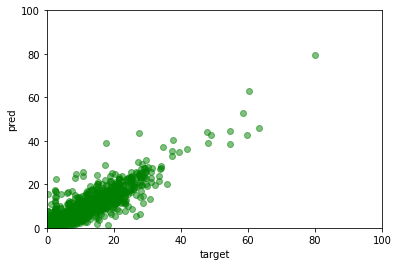

In [21]:
plt.scatter(target, pred, c="g", alpha=0.5)

plt.xlabel("target")
plt.ylabel("pred")

plt.ylim(0,100)
plt.xlim(0,100)
plt.show()